In [1]:
!pip install SimpleITK
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.transform as trans
import random as r
from keras.models import Sequential,load_model,Model,model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D,concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from scipy.ndimage.filters import gaussian_filter 
from scipy.ndimage.interpolation import map_coordinates

K.tensorflow_backend._get_available_gpus()
import SimpleITK as sitk
import tensorflow as tf

     |████████████████████████████████| 42.5MB 1.7MB/s 


Using TensorFlow backend.
W0719 20:00:36.255867 140072528820096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0719 20:00:36.257961 140072528820096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0719 20:00:36.259608 140072528820096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0719 20:00:37.801841 140072528820096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [0]:
K.set_image_dim_ordering("th")


img_size = 128      #original img size is 240*240
smooth = 0.005 
num_of_aug = 2
num_epoch = 60
pul_seq = 'Flair'
sharp = False       # sharpen filter
LR = 1e-4
dropout = 0.2

num_of_patch = 4 #must be a square number
label_num = 5   # 1 = necrosis+NET, 2 = tumor core,3= original, 4 = ET, 5 = complete tumor


from google.colab import drive
from pathlib import Path
drive.mount('/content/drive', force_remount=True)
GDRIVE_DIR = Path("/content/drive/My Drive/Colab Notebooks/2018")

Mounted at /content/drive


In [0]:
def augmentation(scans,labels,n):          #input img must be rank 4 
    datagen = ImageDataGenerator(
        featurewise_center=False,   
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=25,   
        #width_shift_range=0.3,  
        #height_shift_range=0.3,   
        horizontal_flip=True,   
        vertical_flip=True,  
        zoom_range=False)
    i=0
    scans_g=scans.copy()
    for batch in datagen.flow(scans, batch_size=1, seed=1000): 
        scans_g=np.vstack([scans_g,batch])
        i += 1
        if i == n:
            break
#         remember arg + labels  
    i=0
    labels_g=labels.copy()
    for batch in datagen.flow(labels, batch_size=1, seed=1000): 
        labels_g=np.vstack([labels_g,batch])
        i += 1
        if i > n:
            break    
    return ((scans_g,labels_g))
#     return scans_g
#scans_g,labels_g = augmentation(img,img1, 10)
#X_train = X_train.reshape(X_train.shape[0], 1, img_size, img_size)
    
#%%


In [0]:
# function to read all data (training and label) and transform into numpy array
import glob
#function to read one subject data
def create_data(src, mask1,mask2, label=False, resize=(155,img_size,img_size)):
    files = glob.glob(src + mask1, recursive=True)
    labels = glob.glob(src + mask2, recursive=True)
    r.seed(9)
#     r.shuffle(files)    # shuffle patients
    imgs = []
    lbls = []
    print('Processing---', mask1)
    i = 0
    for file in files:
        img = io.imread(file, plugin='simpleitk')
        label = io.imread(labels[i], plugin='simpleitk')
        print(file)
        print(labels[i])
        img = trans.resize(img, resize, mode='constant')
        label = trans.resize(label, resize, mode='constant')
        print(np.shape(label))
        print(np.shape(img))
        if label_num == 5:
            label[label != 0] = 1       #Region 1 => 1+2+3+4 complete tumor
        if label_num == 1:
            label[label != 1] = 0       #only left necrosis and NET
        if label_num == 2:
            label[label == 2] = 0       #turn edema to 0
            label[label != 0] = 1       #only keep necrosis, ET, NET = Tumor core
        if label_num == 4:
            label[label != 4] = 0       #only left ET
            label[label == 4] = 1
        if label_num == 3:
            label[label == 3] = 1       # remain GT, design for 2015 data
                
                
        label = label.astype('float32')
        img = (img-(img[img > 0]).mean()) / (img[img > 0]).std()       #normalization => zero mean   !!!care for the std=0 problem
        img = img.astype('float32')
        for slice in range(60,130):     #choose the slice range
            img_t = img[slice,:,:]
            img_t =img_t.reshape((1,)+img_t.shape)
            img_t =img_t.reshape((1,)+img_t.shape)   #become rank 4
            
            label_t = label[slice,:,:]
            label_t = label_t.reshape((1,)+label_t.shape)
            label_t = label_t.reshape((1,)+label_t.shape)   #become rank 4
            
            print(np.shape(label_t))
            print(np.shape(img_t))
            
            
            img_g,label_g = augmentation(img_t,label_t,num_of_aug)
            for n in range(img_g.shape[0]):
                imgs.append(img_g[n,:,:,:])
                lbls.append(label_g[n,:,:,:])
        i = i + 1
#         break;
    
    return np.array(imgs),np.array(lbls)

In [0]:
#@title
# function to read all data (training and label) and transform into numpy array
import glob
def create_data(src, mask, label=False, resize=(155,img_size,img_size)):
    files = glob.glob(src + mask, recursive=True)
    r.seed(9)
#     r.shuffle(files)    # shuffle patients
    imgs = []
    print('Processing---', mask1)
    for file in files:
        img = io.imread(file, plugin='simpleitk')
        print(file)
        print(file)
        img = trans.resize(img, resize, mode='constant')
        if label:
            if label_num == 5:
                img[img != 0] = 1       #Region 1 => 1+2+3+4 complete tumor
            if label_num == 1:
                img[img != 1] = 0       #only left necrosis and NET
            if label_num == 2:
                img[img == 2] = 0       #turn edema to 0
                img[img != 0] = 1       #only keep necrosis, ET, NET = Tumor core
            if label_num == 4:
                img[img != 4] = 0       #only left ET
                img[img == 4] = 1
            if label_num == 3:
                img[img == 3] = 1       # remain GT, design for 2015 data
                
                
            img = img.astype('float32')
        else:
#             img = n4itk(img)
            img = cv2.equalizeHist(img)
            img = (img-(img[img > 0]).mean()) / (img[img > 0]).std()       #normalization => zero mean   !!!care for the std=0 problem
            img = img.astype('float32')
        for slice in range(60,130):     #choose the slice range
            img_t = img[slice,:,:]
            img_t =img_t.reshape((1,)+img_t.shape)
            img_t =img_t.reshape((1,)+img_t.shape)   #become rank 4
            #img_g = augmentation(img_t,num_of_aug)
            for n in range(img_t.shape[0]):
                imgs.append(img_t[n,:,:,:])
    
    return np.array(imgs)

In [0]:
import cv2
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [0]:
! ls -l --block-size=M

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')
pul_seq = 'flair'
img,label_ht = create_data('/content/drive/My Drive/Colab Notebooks/2018/', '**/*{}.nii.gz'.format(pul_seq),'**/*seg.nii.gz', label=False, resize=(155,img_size,img_size))
# print(np.shape(img))
# label_ht = create_data('/content/drive/My Drive/Colab Notebooks/2018/',  '**/*seg.nii.gz', label=True, resize=(155,img_size,img_size))

In [0]:
np.save(GDRIVE_DIR / 'x_128_all.npy', img)
np.save(GDRIVE_DIR / 'y_128_all.npy', label_ht)


In [0]:
x = np.load(GDRIVE_DIR / 'x_128_all.npy')
y = np.load(GDRIVE_DIR / 'y_128_all.npy')

In [0]:
#@title
# our U-net for full tumor segmentation
from keras.regularizers import l2
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
  
def convert_to_logits(y_pred):
    # see https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    return tf.log(y_pred / (1 - y_pred))

def weighted_cross_entropy_loss(y_true, y_pred):
  y_pred = convert_to_logits(y_pred)
  loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=1)

  return tf.reduce_mean(loss)

def combined_loss(y_true, y_pred):
    return weighted_cross_entropy_loss(y_true, y_pred) + dice_coef_loss(y_true, y_pred)


def unet_model():
    inputs = Input((1, img_size, img_size))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same',bias_initializer='zeros',) (inputs)
    batch1 = BatchNormalization(axis=3)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same',bias_initializer='zeros') (batch1)
    batch1 = BatchNormalization(axis=3)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    pool1 = Dropout(dropout*0.5)(pool1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same',bias_initializer='zeros') (pool1)
    batch2 = BatchNormalization(axis=3)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same',bias_initializer='zeros') (batch2)
    batch2 = BatchNormalization(axis=3)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    pool2 = Dropout(dropout)(pool2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same',bias_initializer='zeros') (pool2)
    batch3 = BatchNormalization(axis=3)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same',bias_initializer='zeros') (batch3)
    batch3 = BatchNormalization(axis=3)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
    pool3 = Dropout(dropout)(pool3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same',bias_initializer='zeros') (pool3)
    batch4 = BatchNormalization(axis=3)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same',bias_initializer='zeros') (batch4)
    batch4 = BatchNormalization(axis=3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)
    pool4 = Dropout(dropout)(pool4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same',bias_initializer='zeros') (pool4)
    batch5 = BatchNormalization(axis=3)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same',bias_initializer='zeros') (batch5)
    batch5 = BatchNormalization(axis=3)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same',bias_initializer='zeros') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same',bias_initializer='zeros') (up6)
    batch6 = BatchNormalization(axis=3)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same',bias_initializer='zeros') (batch6)
    batch6 = BatchNormalization(axis=3)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same',bias_initializer='zeros') (up7)
    batch7 = BatchNormalization(axis=3)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same',bias_initializer='zeros') (batch7)
    batch7 = BatchNormalization(axis=3)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same',bias_initializer='zeros') (up8)
    batch8 = BatchNormalization(axis=3)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same',bias_initializer='zeros') (batch8)
    batch8 = BatchNormalization(axis=3)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same',bias_initializer='zeros') (up9)
    batch9 = BatchNormalization(axis=3)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same',bias_initializer='zeros') (batch9)
    batch9 = BatchNormalization(axis=3)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=LR), loss=combined_loss, metrics=[dice_coef])

    return model

In [0]:
import json,codecs
import numpy as np
def saveHist(history):
    path = history_path
    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
           if  type(history.history[key][0]) == np.float64:
               new_hist[key] = list(map(float, history.history[key]))

    print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist():
    path = history_path
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n

In [0]:
#%%
model_dir = GDRIVE_DIR / 'models'
model_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path =  model_dir /"model-saved.hdf5"
history_path =  model_dir /"history.json"


#training
num = 31100
model = unet_model()
print(model.metrics_names)

# Keep only a single checkpoint, the best over test accuracy.
checkpoint = ModelCheckpoint(str(checkpoint_path),
                monitor='val_dice_coef',
                save_best_only=True,
                mode='max',
                period=1)

ModelCheckpoint('weights.hdf5',
                monitor='val_mean_pred',
                save_best_only=True,
                save_weights_only=True,
                mode='max',
                period=1)

# if len(saved_checkpoints) > 0:
#   last_checkpoint = saved_checkpoints[0]
#   print("Resume training from " + last_checkpoint)
#   model.load_weights(model_dir / last_checkpoint)
# else:
#   print("Traning from scratch!")
history = model.fit(x, y, batch_size=32, validation_split=0.2 ,epochs= num_epoch, verbose=1, shuffle=True, callbacks = [checkpoint])
saveHist(history)
model.summary()

['loss', 'dice_coef']


W0714 08:30:24.618483 140147408443264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15960 samples, validate on 3990 samples
Epoch 1/60
15960/15960 [==============================] - 471s 30ms/step - loss: 0.9963 - dice_coef: 0.3911 - val_loss: 0.7322 - val_dice_coef: 0.3628
Epoch 2/60
15960/15960 [==============================] - 447s 28ms/step - loss: 0.3896 - dice_coef: 0.7921 - val_loss: 0.6063 - val_dice_coef: 0.4608
Epoch 3/60
15960/15960 [==============================] - 447s 28ms/step - loss: 0.2857 - dice_coef: 0.8533 - val_loss: 0.4981 - val_dice_coef: 0.5586
Epoch 4/60
15960/15960 [==============================] - 447s 28ms/step - loss: 0.1990 - dice_coef: 0.9056 - val_loss: 0.4995 - val_dice_coef: 0.5782
Epoch 5/60
15960/15960 [==============================] - 446s 28ms/step - loss: 0.1652 - dice_coef: 0.9231 - val_loss: 0.4398 - val_dice_coef: 0.6156
Epoch 6/60
15960/15960 [==============================] - 447s 28ms/step - loss: 0.1345 - dice_coef: 0.9387 - val_loss: 0.4163 - val_dice_coef: 0.6421
Epoch 7/60
15960/15960 [=====================

In [0]:
#%%
model_dir = GDRIVE_DIR / 'models'
model_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path =  model_dir /"model-saved.hdf5"
history_path =  model_dir /"history.json"
model = unet_model()
model.load_weights(checkpoint_path)
history = loadHist()

print(history)

{'dice_coef': [0.3910524140025739, 0.7920885201384847, 0.8532523745880988, 0.9056106734694096, 0.9230966050224495, 0.9386799080330029, 0.9439221900806093, 0.9552659199650126, 0.9721286273839181, 0.9551498828973985, 0.9806562186781327, 0.9774473522540024, 0.9621335339426695, 0.972798776686341, 0.982127306694375, 0.9857920081991899, 0.9871627828829868, 0.9490653238798442, 0.9807540219828, 0.980031716943086, 0.9872736738737962, 0.9886482564428994, 0.9887042658968378, 0.9891373734426379, 0.9901281454808133, 0.9695067953645138, 0.9805500024542175, 0.989731490552276, 0.9909479932079936, 0.9914058657815881, 0.9912488800242432, 0.9918295683418599, 0.9917974028969767, 0.9664253525865406, 0.9406481940644725, 0.9809338989711943, 0.9864753209558644, 0.9894235076760887, 0.9906744177180126, 0.9858816278906992, 0.9868617514022311, 0.9917993882544955, 0.9922671581868241, 0.9923154931319388, 0.9928094577669798, 0.9926886822645526, 0.973457582074598, 0.9894142944412423, 0.9926588982567751, 0.99313317704

In [0]:
# save model and weights
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

pred = model.predict(x[num:num+100])

# model.save('model.h5')
# model_file = drive.CreateFile({'title' : 'model.h5'})
# model_file.SetContentFile('model.h5')
# model_file.Upload()


# model.save_weights('model_weights.h5')
# model_weight = drive.CreateFile({'title' : 'model_weights.h5'})
# model_weight.SetContentFile('model.h5')
# model_weight.Upload()

#model.load_weights('weights.h5')

#%%
# list all data in history
# print(history.history.keys())
# summarize history for accuracy
plt.plot(history['dice_coef'])
plt.plot(history['val_dice_coef'])
plt.title('model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

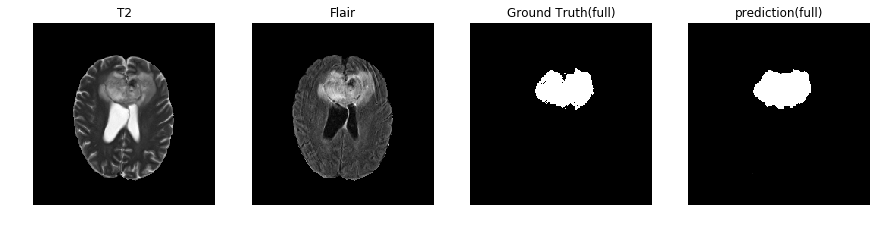

In [0]:
plt.figure(figsize=(15,10))

plt.subplot(141)
plt.title('T2')
plt.axis('off')
plt.imshow(T2[90, 0, :, :],cmap='gray')
    
plt.subplot(142)
plt.title('Flair')
plt.axis('off')
plt.imshow(Flair[90, 0, :, :],cmap='gray')

plt.subplot(143)
plt.title('Ground Truth(full)')
plt.axis('off')
plt.imshow(Label_full[90, 0, :, :],cmap='gray')

plt.subplot(144)
plt.title('prediction(full)')
plt.axis('off')
plt.imshow(pred_full[0, 0, :, :],cmap='gray')

plt.show()